In [1]:
%%capture
! pip install -r requirements.txt

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import shutil
import json
import yaml

In [4]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
device

'cpu'

In [4]:
print(f"Training data size: {len(os.listdir('images_thermal_train/data'))} images")
print(f"Testing data size: {len(os.listdir('images_thermal_val/data'))} images")

Training data size: 10742 images
Testing data size: 1144 images


In [ ]:
END = None  # How many images to process, set to None to process all images
USE_PROGRESS_BAR = True  # Show progress bars (requires tqdm)
VERIFY_FILES = True  # Verify image-label pairs after processing
SKIP_EXISTING = False  # Skip copying if files already exist (set True for faster re-runs)

try:
    from tqdm import tqdm
    HAS_TQDM = True
except ImportError:
    print("Note: Install tqdm for progress bars: pip install tqdm")
    HAS_TQDM = False
    USE_PROGRESS_BAR = False

# -- Create the file structure
def make_file_structure():
    base_dir = "."
    dirs = ["images/train", "images/val", "labels/train", "labels/val"]

    for d in dirs:
        os.makedirs(os.path.join(base_dir, d), exist_ok=True)
    print("✓ Created directory structure")

# -- Add data to images folder (optimized version)
def add_images_to_file(src, dest, start=0, end=None, train=True):
    src_path = os.path.join(src, "data")

    if train:
        dest_path = os.path.join(dest, "train")
    else:
        dest_path = os.path.join(dest, "val")

    # -- Remove existing folder from previous run and make a new one
    if os.path.exists(dest_path) and not SKIP_EXISTING:
        shutil.rmtree(dest_path)
    os.makedirs(dest_path, exist_ok=True)

    # Collecting all the image files (support multiple formats)
    files = [f for f in os.listdir(src_path) 
             if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))]
    files = sorted(files)
    
    # If end is None, process all files
    if end is None:
        end = len(files)
    
    files = files[start:end]
    
    # -- Copying the selected files with progress bar
    copied = 0
    skipped = 0
    
    iterator = tqdm(files, desc=f"Copying {'train' if train else 'val'} images") if (USE_PROGRESS_BAR and HAS_TQDM) else files
    
    for file in iterator:
        dest_file = os.path.join(dest_path, file)
        
        # Skip if file exists and SKIP_EXISTING is True
        if SKIP_EXISTING and os.path.exists(dest_file):
            skipped += 1
            continue
            
        try:
            shutil.copy2(os.path.join(src_path, file), dest_file)
            copied += 1
        except Exception as e:
            print(f"\nError copying {file}: {e}")
    
    print(f"✓ Copied {copied} images to {dest_path}" + (f" (skipped {skipped} existing)" if skipped > 0 else ""))
    return files 

# -- Adding labels to label folder (optimized version)
def add_labels_to_file(src, dest, image_files=None, train=True):
    json_file = os.path.join(src, "coco.json")

    if not os.path.exists(json_file):
        print(f"Error: JSON file not found at {json_file}")
        return

    print(f"Loading annotations from {json_file}...")
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    annotations = data["annotations"]
    images = {img["id"]: img for img in data["images"]}

    # Opening the config file to get class names
    with open("config.yml", "r") as f:
        cfg = yaml.safe_load(f)
    names = [n.lower().strip() for n in cfg["names"]]
    name_to_idx = {n: i for i, n in enumerate(names)}

    # Build mapping by name
    catid_to_idx = {}
    skipped_cats = []
    for cat in data["categories"]:
        cname = cat["name"].lower().strip()
        if cname in name_to_idx:
            catid_to_idx[cat["id"]] = name_to_idx[cname]
        else:
            if cname not in skipped_cats:
                skipped_cats.append(cname)

    if skipped_cats:
        print(f"Note: Skipping {len(skipped_cats)} unmatched categories (this is normal)")

    # Create destination directory if it doesn't exist
    label_dir = os.path.join(dest, "train" if train else "val")
    if os.path.exists(label_dir) and not SKIP_EXISTING:
        shutil.rmtree(label_dir)
    os.makedirs(label_dir, exist_ok=True)
    
    # If image_files is provided, filter to only those images
    if image_files is not None:
        image_filenames = set(image_files)
        # Filter images dict to only include the specified files
        images = {img_id: img_info for img_id, img_info in images.items() 
                  if os.path.basename(img_info["file_name"]) in image_filenames}
    
    # Group annotations by image_id (only for filtered images)
    img_anno = {}
    for anno in annotations:
        img_id = anno["image_id"]
        if img_id in images:
            if img_id not in img_anno:
                img_anno[img_id] = []
            img_anno[img_id].append(anno)
    
    # Process each image with progress bar
    processed = 0
    empty_labels = 0
    iterator = tqdm(img_anno.items(), desc=f"Processing {'train' if train else 'val'} labels") if (USE_PROGRESS_BAR and HAS_TQDM) else img_anno.items()
    
    for img_id, annos in iterator:
        img_info = images[img_id]
        img_width = img_info["width"]
        img_height = img_info["height"]
        img_filename = img_info["file_name"]

        # Extract just the filename
        base_filename = os.path.basename(img_filename)
        
        # Create label files
        label_filename = os.path.splitext(base_filename)[0] + ".txt"
        label_path = os.path.join(dest, "train" if train else "val", label_filename)

        # Skip if exists and SKIP_EXISTING is True
        if SKIP_EXISTING and os.path.exists(label_path):
            processed += 1
            continue

        # Write in YOLO format
        label_lines = []
        for anno in annos:
            category_id = anno["category_id"]
            
            if category_id not in catid_to_idx:
                continue
                
            class_idx = catid_to_idx[category_id]

            bbox = anno["bbox"]
            x, y, w, h = bbox
            
            # Validate bounding box
            if w <= 0 or h <= 0 or x < 0 or y < 0:
                continue
                
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            w_norm = w / img_width
            h_norm = h / img_height
            
            # Validate normalized coordinates
            if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < w_norm <= 1 and 0 < h_norm <= 1):
                continue

            label_lines.append(f"{class_idx} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")
        
        # Write label file (even if empty - YOLO allows empty label files)
        with open(label_path, "w") as l:
            l.writelines(label_lines)
        
        if len(label_lines) == 0:
            empty_labels += 1
        
        processed += 1
    
    print(f"✓ Processed {processed} label files in {label_dir}" + 
          (f" ({empty_labels} empty)" if empty_labels > 0 else ""))

# -- Verify image-label pairs
def verify_dataset(train=True):
    """Verify that each image has a corresponding label file"""
    split = "train" if train else "val"
    img_dir = f"images/{split}"
    label_dir = f"labels/{split}"
    
    if not os.path.exists(img_dir) or not os.path.exists(label_dir):
        print(f"Warning: Directories don't exist for {split} set")
        return
    
    img_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))}
    label_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir) 
                   if f.endswith('.txt')}
    
    missing_labels = img_files - label_files
    missing_images = label_files - img_files
    
    if missing_labels:
        print(f"⚠ Warning: {len(missing_labels)} images without labels in {split} set")
    if missing_images:
        print(f"⚠ Warning: {len(missing_images)} labels without images in {split} set")
    
    if not missing_labels and not missing_images:
        print(f"✓ {split} set: All {len(img_files)} images have matching labels")
    
    return len(img_files), len(label_files)

# -- Main processing
print("=" * 60)
print("Processing FLIR Thermal Dataset")
print("=" * 60)

make_file_structure()

print("\n[1/4] Processing training images...")
train_files = add_images_to_file(
    "images_thermal_train", 
    "./images", start=0, end=END, train=True
)

print("\n[2/4] Processing training labels...")
add_labels_to_file(
    "images_thermal_train", 
    "./labels", image_files=train_files, train=True
)

print("\n[3/4] Processing validation images...")
val_files = add_images_to_file(
    "images_thermal_val", 
    "./images", start=0, end=END, train=False
)

print("\n[4/4] Processing validation labels...")
add_labels_to_file(
    "images_thermal_val", 
    "./labels", image_files=val_files, train=False
)

if VERIFY_FILES:
    print("\n" + "=" * 60)
    print("Verifying dataset integrity...")
    print("=" * 60)
    verify_dataset(train=True)
    verify_dataset(train=False)
    print("\n✓ Dataset processing complete!")

Processing FLIR Thermal Dataset
✓ Created directory structure

[1/4] Processing training images...


Copying train images: 100%|██████████| 10742/10742 [00:32<00:00, 332.73it/s]


✓ Copied 10742 images to ./images\train

[2/4] Processing training labels...
Loading annotations from C:\Users\youch\OneDrive - Cal Poly Pomona\FLIR_ADAS_v2\images_thermal_train\coco.json...
Note: Skipping 65 unmatched categories (this is normal)


Processing train labels: 100%|██████████| 10478/10478 [00:11<00:00, 896.72it/s]


✓ Processed 10478 label files in ./labels\train

[3/4] Processing validation images...


Copying val images: 100%|██████████| 1144/1144 [00:04<00:00, 261.29it/s]


✓ Copied 1144 images to ./images\val

[4/4] Processing validation labels...
Loading annotations from C:\Users\youch\OneDrive - Cal Poly Pomona\FLIR_ADAS_v2\images_thermal_val\coco.json...
Note: Skipping 65 unmatched categories (this is normal)


Processing val labels: 100%|██████████| 1128/1128 [00:00<00:00, 1358.10it/s]

✓ Processed 1128 label files in ./labels\val

Verifying dataset integrity...
⚠ Warning: 264 images without labels in train set
⚠ Warning: 16 images without labels in val set

✓ Dataset processing complete!


Found 10478 matched image-label pairs
Visualizing first 5 samples:



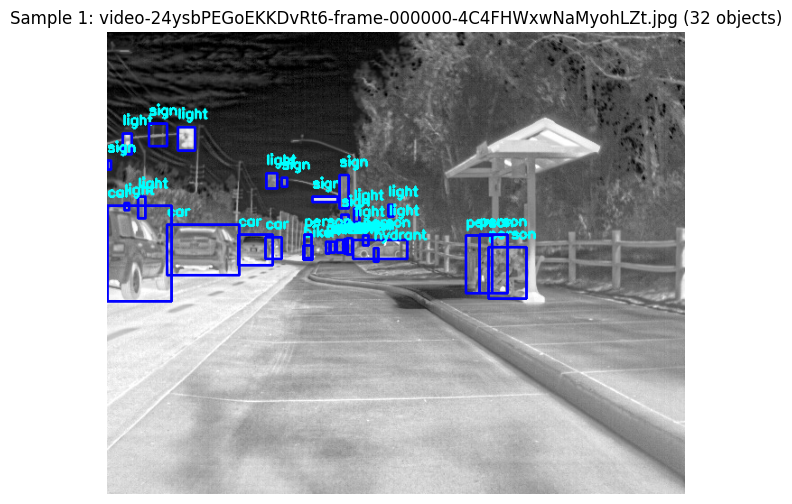

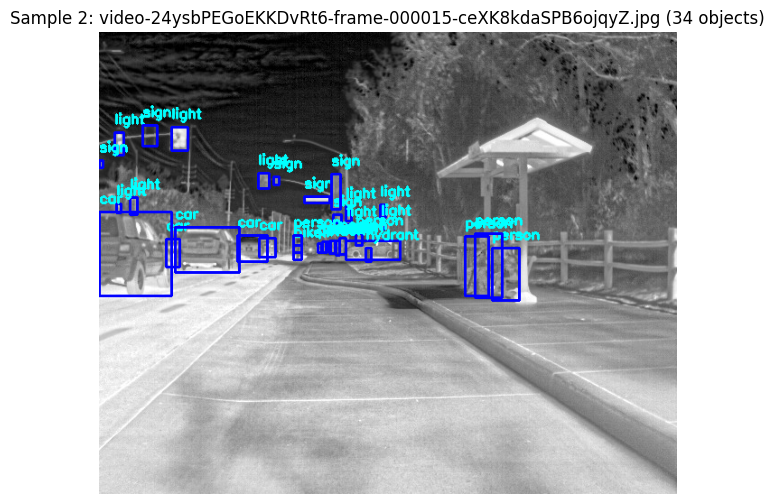

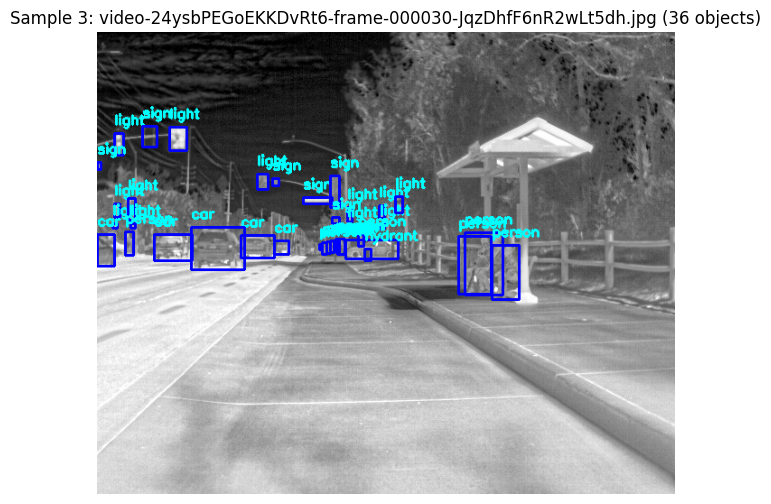

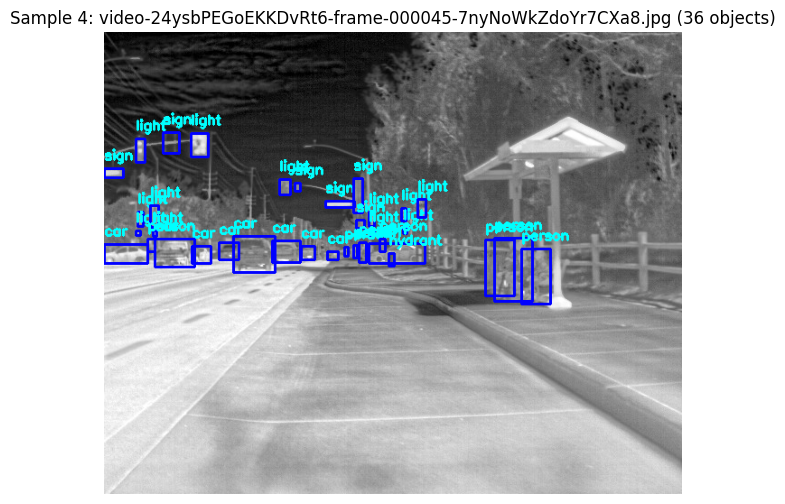

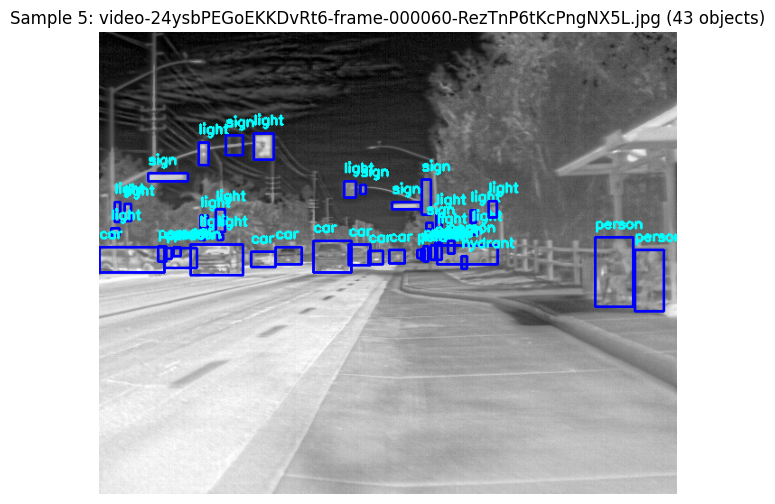

In [15]:
# -- Visualizing sample images and annotations
import cv2
import yaml

with open("config.yml", "r") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml["names"]

# Sort files to ensure matching images and label files
img_files = sorted([f for f in os.listdir('./images/train') 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
label_files = sorted([f for f in os.listdir('./labels/train') if f.endswith('.txt')])

# Match image and label files by base name
matched_pairs = []
img_basenames = {os.path.splitext(f)[0]: f for f in img_files}
for label_file in label_files:
    base_name = os.path.splitext(label_file)[0]
    if base_name in img_basenames:
        matched_pairs.append((img_basenames[base_name], label_file))

print(f"Found {len(matched_pairs)} matched image-label pairs")
print(f"Visualizing first 5 samples:\n")

# Visualize first 5 samples
for i in range(min(5, len(matched_pairs))):
    img_file, label_file = matched_pairs[i]
    img_path = os.path.join("./images/train", img_file)
    label_path = os.path.join("./labels/train", label_file)
    
    first_img = cv2.imread(img_path)
    if first_img is None:
        print(f"Warning: Could not read image {img_path}")
        continue
    
    # Read annotations
    with open(label_path, 'r') as f:
        annot_lines = [line.strip() for line in f.readlines() if line.strip()]
    
    # Draw bounding boxes
    for line in annot_lines:
        parts = line.split()
        if len(parts) >= 5:
            cls, xc, yc, w, h = parts[0], parts[1], parts[2], parts[3], parts[4]
            
            # Convert normalized coordinates to pixel coordinates
            img_h, img_w = first_img.shape[:2]
            x_center = float(xc) * img_w
            y_center = float(yc) * img_h
            width = float(w) * img_w
            height = float(h) * img_h
            
            # Calculate corner coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            
            # Draw rectangle
            cv2.rectangle(first_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            
            # Draw label
            label = class_names[int(cls)]
            cv2.putText(first_img, label, (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {i+1}: {img_file} ({len(annot_lines)} objects)")
    plt.axis(False)
    plt.show()

In [16]:
# -- Dataset Statistics and Analysis
from collections import Counter
import yaml

def analyze_dataset(split='train'):
    """Analyze dataset statistics"""
    img_dir = f"images/{split}"
    label_dir = f"labels/{split}"
    
    if not os.path.exists(img_dir) or not os.path.exists(label_dir):
        print(f"Error: {split} directory not found")
        return
    
    with open("config.yml", "r") as f:
        cfg = yaml.safe_load(f)
    class_names = cfg["names"]
    
    # Count files
    img_files = [f for f in os.listdir(img_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    
    # Count objects per class
    class_counts = Counter()
    total_objects = 0
    empty_labels = 0
    label_errors = 0
    
    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        try:
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            
            if len(lines) == 0:
                empty_labels += 1
                continue
            
            for line in lines:
                parts = line.split()
                if len(parts) >= 5:
                    try:
                        cls_idx = int(parts[0])
                        if 0 <= cls_idx < len(class_names):
                            class_counts[cls_idx] += 1
                            total_objects += 1
                        else:
                            label_errors += 1
                    except ValueError:
                        label_errors += 1
                else:
                    label_errors += 1
        except Exception as e:
            print(f"Error reading {label_file}: {e}")
            label_errors += 1
    
    # Print statistics
    print(f"\n{'='*60}")
    print(f"Dataset Statistics: {split.upper()} Set")
    print(f"{'='*60}")
    print(f"Total images: {len(img_files)}")
    print(f"Total labels: {len(label_files)}")
    print(f"Total objects: {total_objects}")
    print(f"Empty label files: {empty_labels}")
    if label_errors > 0:
        print(f"⚠ Label errors: {label_errors}")
    
    print(f"\nObjects per class:")
    print(f"{'Class':<20} {'Count':<10} {'Percentage':<10}")
    print("-" * 40)
    for cls_idx in sorted(class_counts.keys()):
        count = class_counts[cls_idx]
        pct = (count / total_objects * 100) if total_objects > 0 else 0
        print(f"{class_names[cls_idx]:<20} {count:<10} {pct:>6.2f}%")
    
    if len(class_counts) < len(class_names):
        print(f"\n⚠ Warning: {len(class_names) - len(class_counts)} classes have no annotations")
    
    return {
        'images': len(img_files),
        'labels': len(label_files),
        'objects': total_objects,
        'class_counts': dict(class_counts),
        'empty_labels': empty_labels
    }

# Analyze both train and val sets
train_stats = analyze_dataset('train')
val_stats = analyze_dataset('val')


Dataset Statistics: TRAIN Set
Total images: 10742
Total labels: 10478
Total objects: 175032
Empty label files: 0

Objects per class:
Class                Count      Percentage
----------------------------------------
person               50478       28.84%
bike                 7237         4.13%
car                  73623       42.06%
motor                1116         0.64%
bus                  2245         1.28%
train                5            0.00%
truck                829          0.47%
light                16198        9.25%
hydrant              1095         0.63%
sign                 20770       11.87%
dog                  4            0.00%
skateboard           29           0.02%
stroller             15           0.01%
scooter              15           0.01%
other vehicle        1373         0.78%

Dataset Statistics: VAL Set
Total images: 1144
Total labels: 1128
Total objects: 16696
Empty label files: 0

Objects per class:
Class                Count      Percentage
----------

In [8]:
# -- USED TO CHECK LABEL FILES FOR ERRORS --

# import glob, os, yaml
# from collections import Counter

# with open("config.yml") as f:
#     names = yaml.safe_load(f)["names"]
# nc = len(names)

# train_imgs = sorted(glob.glob("images/train/*"))
# val_imgs   = sorted(glob.glob("images/val/*"))
# train_labs = sorted(glob.glob("labels/train/*.txt"))
# val_labs   = sorted(glob.glob("labels/val/*.txt"))
# print(f"train: {len(train_imgs)} imgs / {len(train_labs)} labels | val: {len(val_imgs)} / {len(val_labs)}")

# empty=0
# rng=0
# hist=Counter()

# for lf in train_labs+val_labs:
#     lines=[l.strip() for l in open(lf) if l.strip()]
#     if not lines: 
#         empty+=1 
#         continue
#     for ln in lines:
#         c,xc,yc,w,h=ln.split()[:5]

#         c=int(float(c))
#         xc=float(xc)
#         yc=float(yc)
#         w=float(w)
#         h=float(h)

#         if not (0<=c<nc and 0<=xc<=1 and 0<=yc<=1 and 0<w<=1 and 0<h<=1):
#             rng+=1
#         else: 
#             hist[c]+=1

# print("empty label files:", empty, "| range/format errors:", rng)
# print({names[k]: v for k,v in hist.items()})


# Model

In [17]:
# ===== Training Configuration =====
EPOCHS = 150  # Increased for better convergence (thermal datasets often need more epochs)
BATCH_SIZE = 16  # Adjust based on GPU memory: 8/16/32
IMG_SIZE = 832  # Can increase to 832 or 1024 for better small object detection
MODEL_SIZE = "yolov8m.pt"

from ultralytics import YOLO

# Initialize model
model = YOLO(MODEL_SIZE)

# Train with optimized parameters for thermal datasets
model.train(
    data="config.yml",
    imgsz=IMG_SIZE,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    device=device,
    
    # Learning rate and optimization
    lr0=0.01,           # Initial learning rate
    lrf=0.01,           # Final learning rate (lr0 * lrf)
    momentum=0.937,     # SGD momentum or Adam beta1
    weight_decay=0.0005, # Optimizer weight decay
    warmup_epochs=3.0,   # Warmup epochs
    warmup_momentum=0.8, # Warmup initial momentum
    warmup_bias_lr=0.1,  # Warmup initial bias lr
    optimizer='auto',    # Optimizer: SGD, Adam, AdamW, NAdam, RAdam, RMSProp
    
    # Augmentation (adjusted for thermal images)
    hsv_h=0.01,         # Image HSV-Hue augmentation (fraction) - REDUCED for thermal
    hsv_s=0.5,          # Image HSV-Saturation augmentation (fraction) - REDUCED for thermal
    hsv_v=0.4,          # Image HSV-Value augmentation (fraction)
    degrees=10.0,       # Image rotation (+/- deg) - good for thermal
    translate=0.1,      # Image translation (+/- fraction)
    scale=0.5,          # Image scale (+/- gain)
    shear=5.0,          # Image shear (+/- deg)
    perspective=0.0,    # Image perspective (+/- fraction), range 0-0.001
    flipud=0.0,         # Image flip up-down (probability)
    fliplr=0.5,         # Image flip left-right (probability)
    mosaic=1.0,         # Image mosaic (probability) - good for dataset diversity
    mixup=0.1,          # Image mixup (probability) - helps with generalization
    copy_paste=0.0,     # Segment copy-paste (probability) - disable for detection
    
    # Training settings
    close_mosaic=10,    # Disable mosaic augmentation for final N epochs
    multi_scale=False,  # Set to True for multi-scale training (slower but better)
    cos_lr=False,       # Cosine LR scheduler (recommended: True for longer training)
    patience=30,        # Early stopping patience (epochs)
    save=True,          # Save train checkpoints and predict results
    save_period=-1,     # Save checkpoint every x epochs (disabled when <1)
    
    # Validation
    val=True,           # Validate/test during training
    split='val',        # Dataset split to use for validation: val, test, or train
    
    # Other important parameters
    cache=False,        # Cache images in memory/disk for faster training (True/ram/disk)
    workers=8,          # Max dataloader workers (per RANK if DDP)
    project=None,       # Project name (default: runs/detect)
    name='train',       # Experiment name (default: train, train2, train3, ...)
    exist_ok=True,      # Existing project/name ok, do not increment
    pretrained=True,    # Whether to use pretrained weights
    verbose=True,       # Verbose output
    seed=0,             # Random seed for reproducibility
    
    # Loss weights (fine-tuning these can help)
    box=7.5,            # Box loss gain
    cls=0.5,            # Class loss gain
    dfl=1.5,            # DFL loss gain
    
    # Advanced
    amp=True,           # Automatic Mixed Precision (AMP) training
    fraction=1.0,       # Dataset fraction to train on
    profile=False,      # Profile ONNX and TensorRT speeds during validation
    freeze=None,        # Freeze layers: backbone=10, first3=0 1 2
)

New https://pypi.org/project/ultralytics/8.4.7 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.225  Python-3.13.9 torch-2.9.0+cpu CPU (13th Gen Intel Core(TM) i7-13620H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config.yml, degrees=10.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.4, imgsz=832, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=Fal

KeyboardInterrupt: 

In [ ]:
# -- Evaulation

metrics = model.val()
metrics = vars(metrics)

for k,v in metrics.items():
    print(f"{k}: {v}")


In [ ]:
# -- Inference

model = YOLO("runs/detect/train/weights/best.pt")
results = model.predict(source="images/val",
                        imgsz=1280, 
                        conf=0.5,
                        iou=0.35,
                        save=True,
                        max_det=1000,
                        save_txt=True,
                        save_conf=True, 
                        device=device)
print(f"Inference saved to: {results[0].save_dir}")

In [ ]:
# -- Save Model
model.export(format="onnx")